# Amir Voloshin
## Zira Computer Vision Developer Test: Custom Object Detection Model Development

## Table of Contents
1. Parts 1-5: Dataset Preparation, Training Custom Model, Model Validation, Model Compilation, Advanced/Optional: Apply Model Quantization
2. Model Validation Report
3. Model Testing: Object Detection on Test Set, Model Testing on Video
4. Extra (Training Model with more epochs)
5. Extra Model Validation Report
6. Object Detection in Video with Extra Model

In [ ]:
# Run this to access Google Drive for the data
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# tflite model maker workaround
tflite model maker isn't compatible with python 3.10 (the version on google colab) so using a workaround

In [ ]:
# Source: //discuss.tensorflow.org/t/running-tflite-model-maker-in-google-colab-june-july-2023/18049
%env PYTHONPATH = # /env/python

env: PYTHONPATH=# /env/python


In [ ]:
# Download and install and update miniconda (you will need to hit y to proceed) #
!wget https://repo.anaconda.com/miniconda/Miniconda3-py39_23.3.1-0-Linux-x86_64.sh
!chmod +x Miniconda3-py39_23.3.1-0-Linux-x86_64.sh
!./Miniconda3-py39_23.3.1-0-Linux-x86_64.sh -b -f -p /usr/local
!conda update -q conda

--2024-01-04 04:59:29--  https://repo.anaconda.com/miniconda/Miniconda3-py39_23.3.1-0-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70605094 (67M) [application/x-sh]
Saving to: ‘Miniconda3-py39_23.3.1-0-Linux-x86_64.sh.7’

Miniconda3-py39_23. 100%[===================>]  67.33M   111MB/s    in 0.6s    

2024-01-04 04:59:30 (111 MB/s) - ‘Miniconda3-py39_23.3.1-0-Linux-x86_64.sh.7’ saved [70605094/70605094]

PREFIX=/usr/local
Unpacking payload ...

Installing base environment...



Preparing transaction: - done
Executing transaction: | done
installation finished.
    You currently have a PYTHONPATH environment variable set. This may cause
    unexpected behavior when running the Python interpreter in Miniconda3.
    For best results, please verify that your PYTHONPATH only p

In [ ]:
import sys
sys.path.append('/usr/local/lib/python3.9/site-packages')

In [ ]:
# create conda environment (you will need to hit y to proceed) #
!conda create -n myenv python=3.9


# >>>>>>>>>>>>>>>>>>>>>> ERROR REPORT <<<<<<<<<<<<<<<<<<<<<<

    Traceback (most recent call last):
      File "/usr/local/lib/python3.9/site-packages/conda/exceptions.py", line 1132, in __call__
        return func(*args, **kwargs)
      File "/usr/local/lib/python3.9/site-packages/conda/cli/main.py", line 57, in main_subshell
        p = generate_parser()
      File "/usr/local/lib/python3.9/site-packages/conda/cli/conda_argparse.py", line 63, in generate_parser
        p = ArgumentParser(
      File "/usr/local/lib/python3.9/site-packages/conda/cli/conda_argparse.py", line 148, in __init__
        self._subcommands = context.plugin_manager.get_hook_results("subcommands")
      File "/usr/local/lib/python3.9/site-packages/conda/plugins/manager.py", line 100, in get_hook_results
        plugins = sorted(
      File "/usr/local/lib/python3.9/site-packages/conda/plugins/manager.py", line 101, in <genexpr>
        (item for items in hook() for item in items),
      File "/usr/local/lib

In [ ]:
# Install dependencies in the new environment. You need to force activate conda every time
%%shell
eval "$(conda shell.bash hook)"
conda activate myenv
pip install -q tflite-model-maker
pip3 install -q pycocotools
pip install -q ipykernel
pip install -q numpy==1.23.4
#pip install -r ../content/drive/MyDrive/ColabNotebooks/Zira/requirements.txt
#!pip install -q opencv-python-headless==4.1.2.30

# Parts 1-5
Code in 'train.py'

In [ ]:
# Run your training and evaluation script as an external python script
%%shell
eval "$(conda shell.bash hook)"
conda activate myenv

# To use GPU in google colab (faster training time)
conda install cudatoolkit
conda install cudnn
#find / -name 'libcudnn'

# adding shared library objects to the ld library path since it was missing
export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/var/lib/dpkg/alternatives/libcudnn
#find / -name 'libcudart.so.11.0'
export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/usr/local/pkgs/cudatoolkit-11.8.0-h6a678d5_0/lib/
export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/usr/local/envs/myenv/lib/

python /content/drive/MyDrive/ColabNotebooks/Zira/train.py

## Model Validation Report
There is a noticeable difference in the Average Precision between the original and quantized model, surprisingly the difference is in favor of the quantized model. This can be seen with some of the other metrics as well.

COCO metrics **Original Model**: \
AP: 0.44019949436187744 \
AP50: 0.9350011944770813\
AP75: 0.2790553569793701\
APs: -1.0\
APm: 0.20000000298023224\
APl: 0.46230509877204895\
ARmax1: 0.42307692766189575\
ARmax10: 0.5423076748847961\
ARmax100: 0.5423076748847961\
ARs: -1.0\
ARm: 0.20000000298023224\
ARl: 0.5559999942779541\
AP_/boards: 0.44019949436187744\

\
COCO metrics **Quantized Model**: \
AP: 0.4524911642074585\
AP50: 0.9339147806167603\
AP75: 0.3147366940975189\
APs: -1.0\
APm: 0.20000000298023224\
APl: 0.4766516387462616\
ARmax1: 0.4423076808452606\
ARmax10: 0.5615384578704834\
ARmax100: 0.5615384578704834\
ARs: -1.0\
ARm: 0.20000000298023224\
ARl: 0.5759999752044678\
AP_/boards: 0.4524911642074585\

In [ ]:
# Load losses list from file saved in above script
import pickle

# Training Loss
with open("losses.pkl", "rb") as fp:   # Unpickling
  loss = pickle.load(fp)

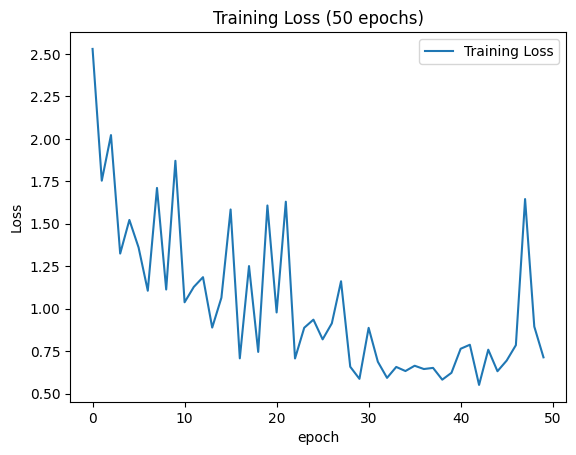

In [ ]:
import matplotlib.pyplot as plt

plt.plot(loss, label = 'Training Loss')

plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.title('Training Loss (50 epochs)')
plt.xlabel('epoch')
plt.show()

# 6. Model Testing

In [ ]:
# 6. Model Testing
# SOURCE: https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/models/modify/model_maker/object_detection.ipynb
import numpy as np
import tensorflow as tf
import cv2
from PIL import Image
import os
import matplotlib.pyplot as plt

# Only need one color, choosing red
COLORS = np.array([[200, 50, 50]], dtype=np.uint8)

# Labels
classes = ['boards']

def preprocess_image(image_path, input_size):
  """Preprocess the input image to feed to the TFLite model"""
  img = tf.io.read_file(image_path)
  img = tf.io.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.uint8)
  original_image = img
  resized_img = tf.image.resize(img, input_size)
  resized_img = resized_img[tf.newaxis, :]
  resized_img = tf.cast(resized_img, dtype=tf.uint8)
  return resized_img, original_image


def detect_objects(interpreter, image, threshold):
  """Returns a list of detection results, each a dictionary of object info."""

  signature_fn = interpreter.get_signature_runner()

  # Feed the input image to the model
  output = signature_fn(images=image)

  # Get all outputs from the model
  count = int(np.squeeze(output['output_0']))
  scores = np.squeeze(output['output_1'])
  classes = np.squeeze(output['output_2'])
  boxes = np.squeeze(output['output_3'])

  results = []
  for i in range(count):
    if scores[i] >= threshold:
      result = {
        'bounding_box': boxes[i],
        'class_id': classes[i],
        'score': scores[i]
      }
      results.append(result)
  return results


def run_odt_and_draw_results(image_path, interpreter, threshold=0.5):
  """Run object detection on the input image and draw the detection results"""
  # Load the input shape required by the model
  _, input_height, input_width, _ = interpreter.get_input_details()[0]['shape']

  # Load the input image and preprocess it
  preprocessed_image, original_image = preprocess_image(
      image_path,
      (input_height, input_width)
    )

  # Run object detection on the input image
  results = detect_objects(interpreter, preprocessed_image, threshold=threshold)

  # Plot the detection results on the input image
  original_image_np = original_image.numpy().astype(np.uint8)
  for obj in results:
    # Convert the object bounding box from relative coordinates to absolute
    # coordinates based on the original image resolution
    ymin, xmin, ymax, xmax = obj['bounding_box']
    xmin = int(xmin * original_image_np.shape[1])
    xmax = int(xmax * original_image_np.shape[1])
    ymin = int(ymin * original_image_np.shape[0])
    ymax = int(ymax * original_image_np.shape[0])

    # Find the class index of the current object
    class_id = int(obj['class_id'])

    # Draw the bounding box and label on the image
    color = [int(c) for c in COLORS[class_id]]
    cv2.rectangle(original_image_np, (xmin, ymin), (xmax, ymax), color, 2)
    # Make adjustments to make the label visible for all objects
    y = ymin - 15 if ymin - 15 > 15 else ymin + 15
    label = "{}: {:.0f}%".format(classes[class_id], obj['score'] * 100)
    cv2.putText(original_image_np, label, (xmin, y),
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

  # Return the final image
  original_uint8 = original_image_np.astype(np.uint8)
  return original_uint8

## Object Detection on Test Set

<ipython-input-364-ddb70254f55f>:13: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im.thumbnail((512, 512), Image.ANTIALIAS)


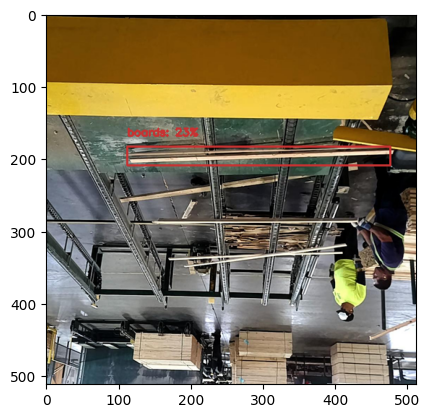

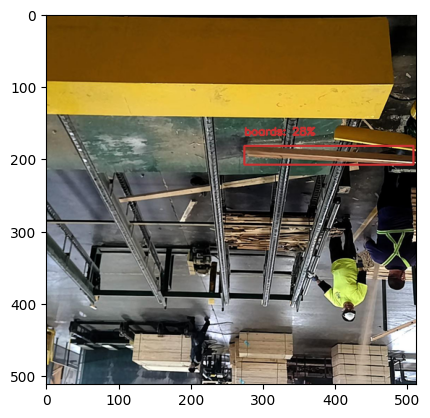

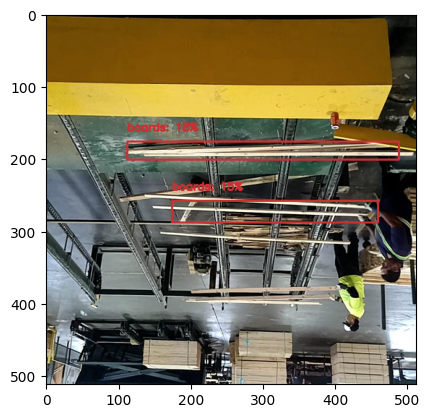

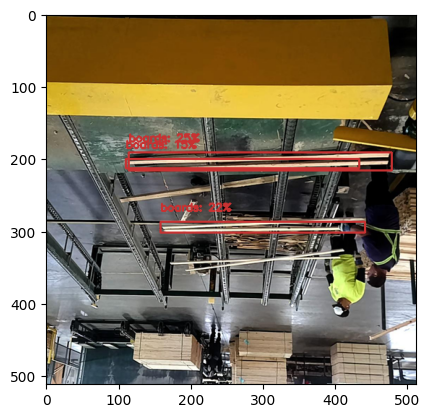

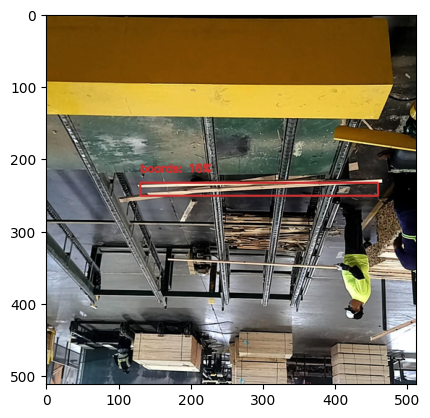

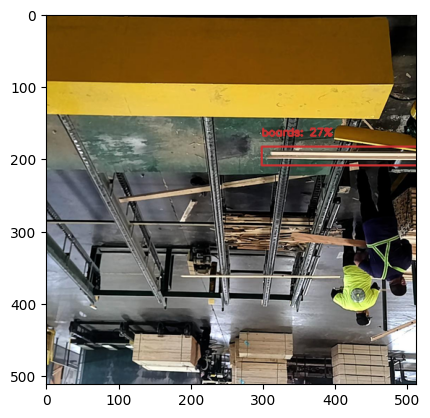

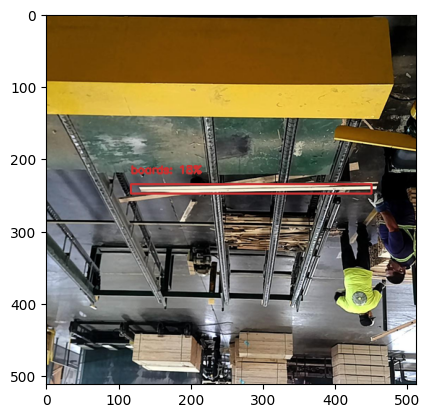

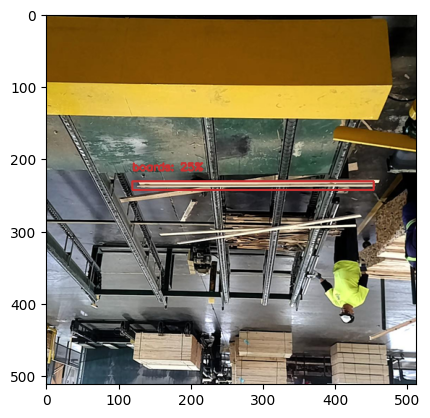

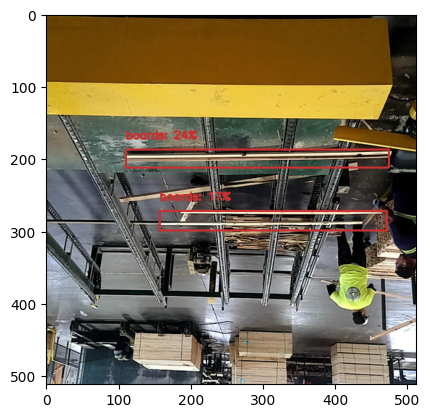

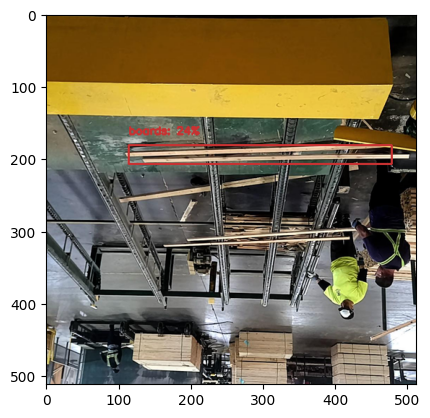

In [ ]:
# # Load the TFLite model
# model_path = 'drive/MyDrive/ColabNotebooks/Zira/quant.tflite'
# interpreter = tf.lite.Interpreter(model_path=model_path)
# interpreter.allocate_tensors()

# # picture directory
# picdir =  'drive/MyDrive/ColabNotebooks/Zira/Riverside_Yates.v1i.voc/test/'
# pics = [p for p in os.listdir('drive/MyDrive/ColabNotebooks/Zira/Riverside_Yates.v1i.voc/test') if '.jpg' in p]

def object_detect(pdir, pic, interpreter):
  TEMP_FILE = pdir + pic
  im = Image.open(TEMP_FILE)
  im.thumbnail((512, 512), Image.ANTIALIAS)
  im.save(TEMP_FILE, 'PNG')
  # Run inference and draw detection result on the local copy of the original file
  detection_result_image = run_odt_and_draw_results(
      TEMP_FILE,
      interpreter,
      threshold=DETECTION_THRESHOLD
  )

  # Show the detection result
  img = Image.fromarray(detection_result_image)
  plt.imshow(img)
  plt.show()


DETECTION_THRESHOLD = 0.15

# Load the TFLite model
model_path = 'drive/MyDrive/ColabNotebooks/Zira/boards.tflite'
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# picture directory
picdir =  'drive/MyDrive/ColabNotebooks/Zira/Riverside_Yates.v1i.voc/test/'
pics = [p for p in os.listdir('drive/MyDrive/ColabNotebooks/Zira/Riverside_Yates.v1i.voc/test') if '.jpg' in p]

# Driver Code for Visualization
for pic in pics:
  object_detect(picdir, pic, interpreter)

## Model Testing on Video

In [ ]:
# SOURCE: https://github.com/EdjeElectronics/TensorFlow-Lite-Object-Detection-on-Android-and-Raspberry-Pi/blob/master/TFLite_detection_video.py
VIDEO_NAME = 'drive/MyDrive/ColabNotebooks/Zira/video3.mp4'
model_path = 'drive/MyDrive/ColabNotebooks/Zira/quant.tflite'
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
height = input_details[0]['shape'][1]
width = input_details[0]['shape'][2]
floating_model = (input_details[0]['dtype'] == np.float32)
input_mean = 127.5
input_std = 127.5

# Open video file
video = cv2.VideoCapture(VIDEO_NAME)
imW = video.get(cv2.CAP_PROP_FRAME_WIDTH)
imH = video.get(cv2.CAP_PROP_FRAME_HEIGHT)

out = cv2.VideoWriter('/content/drive/MyDrive/ColabNotebooks/Zira/output_video.mp4', cv2.VideoWriter_fourcc('m', 'p', '4', 'v'), 25,
                                (int(imW), int(imH)), 3)
cnt = 0
import time
strt = time.time()
print("count--------------", cnt)
while(video.isOpened()):

    # Acquire frame and resize to expected shape [1xHxWx3]
    ret, frame = video.read()
    cnt += 1
    #if cnt == 50: break
    if cnt%200 == 1: print("Number of frames processed so far:", cnt)
    if not ret:
      print('Reached the end of the video!')
      break
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame_resized = cv2.resize(frame_rgb, (width, height))
    input_data = np.expand_dims(frame_resized, axis=0)

    # Normalize pixel values if using a floating model (i.e. if model is non-quantized)
    if floating_model:
        input_data = (np.float32(input_data) - input_mean) / input_std

    # # Perform the actual detection by running the model with the image as input
    # interpreter.set_tensor(input_details[0]['index'],input_data)
    # interpreter.invoke()

    # # Retrieve detection results
    # boxes = interpreter.get_tensor(output_details[boxes_idx]['index'])[0] # Bounding box coordinates of detected objects
    # classes = interpreter.get_tensor(output_details[classes_idx]['index'])[0] # Class index of detected objects
    # scores = interpreter.get_tensor(output_details[scores_idx]['index'])[0] # Confidence of detected objects
    signature_fn = interpreter.get_signature_runner()

    # Feed the input image to the model
    output = signature_fn(images=input_data)

    # Get all outputs from the model
    count = int(np.squeeze(output['output_0']))
    scores = np.squeeze(output['output_1'])
    classes = np.squeeze(output['output_2'])
    boxes = np.squeeze(output['output_3'])

    min_conf_threshold = 0.15
    labels = 'boards'

    # Loop over all detections and draw detection box if confidence is above minimum threshold
    for i in range(len(scores)):
        if ((scores[i] > min_conf_threshold) and (scores[i] <= 1.0)):

            # Get bounding box coordinates and draw box
            # Interpreter can return coordinates that are outside of image dimensions, need to force them to be within image using max() and min()
            ymin = int(max(1,(boxes[i][0] * imH)))
            xmin = int(max(1,(boxes[i][1] * imW)))
            ymax = int(min(imH,(boxes[i][2] * imH)))
            xmax = int(min(imW,(boxes[i][3] * imW)))

            cv2.rectangle(frame, (xmin,ymin), (xmax,ymax), (10, 255, 0), 4)

            # Draw label
            object_name = labels[int(classes[i])] # Look up object name from "labels" array using class index
            label = '%s: %d%%' % (object_name, int(scores[i]*100)) # Example: 'person: 72%'
            labelSize, baseLine = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2) # Get font size
            label_ymin = max(ymin, labelSize[1] + 10) # Make sure not to draw label too close to top of window
            cv2.rectangle(frame, (xmin, label_ymin-labelSize[1]-10), (xmin+labelSize[0], label_ymin+baseLine-10), (255, 255, 255), cv2.FILLED) # Draw white box to put label text in
            cv2.putText(frame, label, (xmin, label_ymin-7), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2) # Draw label text

    # All the results have been drawn on the frame, so it's time to display it.

    # Source from https://stackoverflow.com/questions/72851164/opencv-not-properly-writing-adding-frames-to-video
    # Including from PIL import at the top
    # img_PIL = Image.frombytes('RGB', img0.size, img0.bgra, 'raw', 'BGRX') #This is where we convert it to a Pillow-like image
    # img1= np.array(img_PIL) #Sorry about my variables, I was too lazy to change them :P
    # img = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)



    out.write(frame)  # AV
    #cv2.imshow('frame', frame)
    # Press 'q' to quit
    # if cv2.waitKey(1) == ord('q'):
    #     break

print('Took', time.time() - strt, 'seconds')
# Clean up
video.release()
print("Releasing out")
out.release()
cv2.destroyAllWindows()

count-------------- 0
Number of frames processed so far: 1
Number of frames processed so far: 201
Number of frames processed so far: 401
Number of frames processed so far: 601
Number of frames processed so far: 801
Number of frames processed so far: 1001
Number of frames processed so far: 1201
Number of frames processed so far: 1401
Number of frames processed so far: 1601
Reached the end of the video!
Took 83.57073497772217
Releasing out


# Extra (Training Model with more epochs)

In [ ]:
# Run your training and evaluation script as an external python script
%%shell
eval "$(conda shell.bash hook)"
conda activate myenv

# To use GPU in google colab (faster training time)
conda install cudatoolkit
conda install cudnn
#find / -name 'libcudnn'

# adding shared library objects to the ld library path since it was missing
export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/var/lib/dpkg/alternatives/libcudnn
#find / -name 'libcudart.so.11.0'
export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/usr/local/pkgs/cudatoolkit-11.8.0-h6a678d5_0/lib/
export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/usr/local/envs/myenv/lib/

python /content/drive/MyDrive/ColabNotebooks/Zira/train_long.py

Channels:
 - defaults
Platform: linux-64
Solving environment: / done

## Package Plan ##

  environment location: /usr/local/envs/myenv

  added / updated specs:
    - cudatoolkit


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    cudatoolkit-11.8.0         |       h6a678d5_0       630.7 MB
    ------------------------------------------------------------
                                           Total:       630.7 MB

The following NEW packages will be INSTALLED:

  cudatoolkit        pkgs/main/linux-64::cudatoolkit-11.8.0-h6a678d5_0 


Proceed ([y]/n)? y


                                                                        
Preparing transaction: \ done
Verifying transaction: / - done
Executing transaction: | / - \ By downloading and using the CUDA Toolkit conda packages, you accept the terms and conditions of the CUDA End User License Agreement (EULA): https://docs.nv

In [ ]:
# Load losses list from file saved in above script
import pickle

# Training Loss
with open("losses_long.pkl", "rb") as fp:   # Unpickling
  loss = pickle.load(fp)

# Validation Loss
with open("val_losses_long.pkl", "rb") as fp:   # Unpickling
  val_loss = pickle.load(fp)

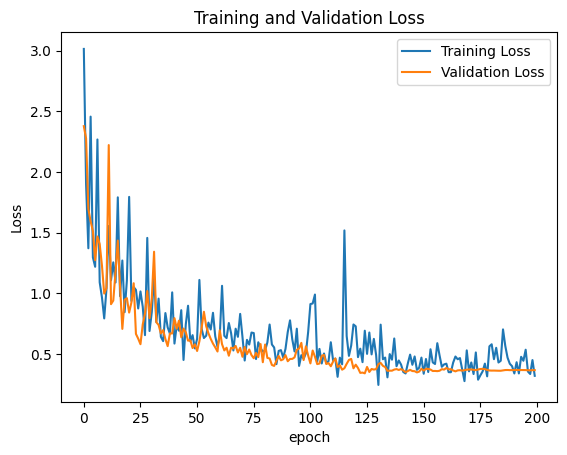

In [ ]:
import matplotlib.pyplot as plt

plt.plot(loss, label = 'Training Loss')
plt.plot(val_loss, label = 'Validation Loss')

# plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Extra Model Validation Report
Once again there is a noticeable difference in the Average Precision between the original and quantized model, surprisingly the difference is in favor of the quantized model. This can be seen with some of the other metrics as well.

COCO metrics **Original Model Longer Training**:\
AP: 0.5614750981330872\
AP50: 0.9760345220565796\
AP75: 0.5791326761245728\
APs: -1.0\
APm: 0.6000000238418579\
APl: 0.5645578503608704\
ARmax1: 0.5038461685180664\
ARmax10: 0.6269230842590332\
ARmax100: 0.6384615302085876\
ARs: -1.0\
ARm: 0.6000000238418579\
ARl: 0.6399999856948853\
AP_/boards: 0.5614750981330872\
\
COCO metrics **Quantized Model Longer Training**:\
AP: 0.6168215274810791\
AP50: 0.9763253927230835\
AP75: 0.7413140535354614\
APs: -1.0\
APm: 0.699999988079071\
APl: 0.618201494216919\
ARmax1: 0.5461538434028625\
ARmax10: 0.6846153736114502\
ARmax100: 0.6846153736114502\
ARs: -1.0\
ARm: 0.699999988079071\
ARl: 0.6840000152587891\
AP_/boards: 0.6168215274810791\

## Object Detection in Video with Extra Model

In [ ]:
VIDEO_NAME = 'drive/MyDrive/ColabNotebooks/Zira/video3.mp4'
model_path = 'drive/MyDrive/ColabNotebooks/Zira/quant_long.tflite'
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
height = input_details[0]['shape'][1]
width = input_details[0]['shape'][2]
floating_model = (input_details[0]['dtype'] == np.float32)
input_mean = 127.5
input_std = 127.5

# Open video file
video = cv2.VideoCapture(VIDEO_NAME)
imW = video.get(cv2.CAP_PROP_FRAME_WIDTH)
imH = video.get(cv2.CAP_PROP_FRAME_HEIGHT)

out = cv2.VideoWriter('/content/drive/MyDrive/ColabNotebooks/Zira/output_video_long.mp4', cv2.VideoWriter_fourcc('m', 'p', '4', 'v'), 25,
                                (int(imW), int(imH)), 3)
cnt = 0
import time
strt = time.time()
print("count--------------", cnt)
while(video.isOpened()):

    # Acquire frame and resize to expected shape [1xHxWx3]
    ret, frame = video.read()
    cnt += 1
    #if cnt == 50: break
    if cnt%200 == 1: print("Number of frames processed so far:", cnt)
    if not ret:
      print('Reached the end of the video!')
      break
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame_resized = cv2.resize(frame_rgb, (width, height))
    input_data = np.expand_dims(frame_resized, axis=0)

    # Normalize pixel values if using a floating model (i.e. if model is non-quantized)
    if floating_model:
        input_data = (np.float32(input_data) - input_mean) / input_std

    # # Perform the actual detection by running the model with the image as input
    # interpreter.set_tensor(input_details[0]['index'],input_data)
    # interpreter.invoke()

    # # Retrieve detection results
    # boxes = interpreter.get_tensor(output_details[boxes_idx]['index'])[0] # Bounding box coordinates of detected objects
    # classes = interpreter.get_tensor(output_details[classes_idx]['index'])[0] # Class index of detected objects
    # scores = interpreter.get_tensor(output_details[scores_idx]['index'])[0] # Confidence of detected objects
    signature_fn = interpreter.get_signature_runner()

    # Feed the input image to the model
    output = signature_fn(images=input_data)

    # Get all outputs from the model
    count = int(np.squeeze(output['output_0']))
    scores = np.squeeze(output['output_1'])
    classes = np.squeeze(output['output_2'])
    boxes = np.squeeze(output['output_3'])

    min_conf_threshold = 0.2
    labels = 'boards'

    # Loop over all detections and draw detection box if confidence is above minimum threshold
    for i in range(len(scores)):
        if ((scores[i] > min_conf_threshold) and (scores[i] <= 1.0)):

            # Get bounding box coordinates and draw box
            # Interpreter can return coordinates that are outside of image dimensions, need to force them to be within image using max() and min()
            ymin = int(max(1,(boxes[i][0] * imH)))
            xmin = int(max(1,(boxes[i][1] * imW)))
            ymax = int(min(imH,(boxes[i][2] * imH)))
            xmax = int(min(imW,(boxes[i][3] * imW)))

            cv2.rectangle(frame, (xmin,ymin), (xmax,ymax), (10, 255, 0), 4)

            # Draw label
            object_name = labels[int(classes[i])] # Look up object name from "labels" array using class index
            label = '%s: %d%%' % (object_name, int(scores[i]*100)) # Example: 'person: 72%'
            labelSize, baseLine = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2) # Get font size
            label_ymin = max(ymin, labelSize[1] + 10) # Make sure not to draw label too close to top of window
            cv2.rectangle(frame, (xmin, label_ymin-labelSize[1]-10), (xmin+labelSize[0], label_ymin+baseLine-10), (255, 255, 255), cv2.FILLED) # Draw white box to put label text in
            cv2.putText(frame, label, (xmin, label_ymin-7), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2) # Draw label text

    # All the results have been drawn on the frame, so it's time to display it.

    # Source from https://stackoverflow.com/questions/72851164/opencv-not-properly-writing-adding-frames-to-video
    # Including from PIL import at the top
    # img_PIL = Image.frombytes('RGB', img0.size, img0.bgra, 'raw', 'BGRX') #This is where we convert it to a Pillow-like image
    # img1= np.array(img_PIL) #Sorry about my variables, I was too lazy to change them :P
    # img = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)



    out.write(frame)  # AV
    #cv2.imshow('frame', frame)
    # Press 'q' to quit
    # if cv2.waitKey(1) == ord('q'):
    #     break

print('Took', time.time() - strt, 'seconds')
# Clean up
video.release()
print("Releasing out")
out.release()
cv2.destroyAllWindows()

count-------------- 0
Number of frames processed so far: 1
Number of frames processed so far: 201
Number of frames processed so far: 401
Number of frames processed so far: 601
Number of frames processed so far: 801
Number of frames processed so far: 1001
Number of frames processed so far: 1201
Number of frames processed so far: 1401
Number of frames processed so far: 1601
Reached the end of the video!
Took 84.27179431915283 seconds
Releasing out
